In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Equity Option - Booking and valuing an Equity Option with physical settlement

Attributes
----------
equity option
recipes
valuations
physical settlement
P&L
"""

toggle_code("Toggle Docstring")

# Booking and valuing an Equity Option with physical settlement

In this notebook, we will demonstrate how you book can book in an equity option with physical settlement. We will calculate the present value of this option and show how the portfolio will look upon expiry date where we physically settle the instrument.

## Table of Contents:
* [1. Create a portfolio](#1.-Create-Portfolio)
* [2. Creating an equity option](#2.-Create-Instruments)
* [3. Transactions](#3.-Transactions)
* [4. Quotes](#4.-Quotes)
* [5. Valuation](#5.-Valuations)
* [6. Physical Settlement](#6.-Physical-Settlement)

In [2]:
# Import generic non-LUSID packages
import os
import pandas as pd
import numpy as np
from datetime import datetime
import json
import pytz
import time
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid as lu
import lusid.models as lm
import fbnsdkutilities.utilities as utils

# Import key functions from Lusid-Python-Tools and other packages
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.cocoon.transaction_type_upload import upsert_transaction_type_alias
from lusidtools.lpt.lpt import to_date
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format
# display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = utils.ApiClientFactory(
    lu, token=RefreshingToken(), api_secrets_filename=secrets_path
)

print("LUSID Environment Initialised")
print(
    "LUSID API Version :",
    api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version,
)

LUSID Environment Initialised
LUSID API Version : 0.6.11252.0


In [3]:
# LUSID Variable Definitions
portfolio_api = api_factory.build(lu.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lu.api.InstrumentsApi)
quotes_api = api_factory.build(lu.api.QuotesApi)
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
system_configuration_api = api_factory.build(lu.api.SystemConfigurationApi)
aggregration_api = api_factory.build(lu.api.AggregationApi)

In [4]:
# Define scopes
scope = "ibor"
quotes_scope = "ibor"
portfolio_code = "equityOptionPortfolio"

# 1. Create Portfolio

Create the portfolio that will contain the Equity Option.

In [5]:
try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="USD",
            created="2010-01-01",
            sub_holding_keys=[],
        ),
    )

except lu.ApiException as e:
    print(json.loads(e.body)["title"])

Could not create a portfolio with id 'equityOptionPortfolio' because it already exists in scope 'ibor'.


# 2. Create Instruments

## 2.1 Create the underlying instruments

In order to create a derivative on an instrument, we must first create that underlying instrument. As we are planning to create CFDs based on Amazon and Apple, we will upsert the underlying stocks first.

In [6]:
# upload AMZN and AAPL Equities

equity = lm.SimpleInstrument(
    instrument_type="SimpleInstrument", 
    dom_ccy="USD", 
    asset_class="Equities", 
    simple_instrument_type="Equity"
)

equity_definition = lm.InstrumentDefinition(
    name="Amazon.com",
    identifiers={"ClientInternal": lm.InstrumentIdValue("AMZN"), "RIC": lm.InstrumentIdValue("AMZN")},
    definition=equity,
)

# upsert the instrument
upsert_request = {"AMZN": equity_definition}
upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
equity_luid = upsert_response.values["AMZN"].lusid_instrument_id
print(equity_luid)

LUID_0000CZRI


## 2.2 Create the Equity Option

Now that we have created the underlying stocks, we can create a function to upsert equity options in LUSID.

In [7]:
def create_option(
    option_name, 
    option_identifier, 
    start_date,
    option_maturity_date, 
    option_settle_date, 
    delivery_type, 
    option_type, 
    strike, 
    dom_ccy,
    underlying_code,
    underlying_identifier,
):

    option = lm.EquityOption( 
        instrument_type="EquityOption", 
        start_date=start_date, 
        option_maturity_date=option_maturity_date,
        option_settlement_date=option_settle_date, 
        delivery_type=delivery_type, 
        option_type=option_type, 
        strike=strike, 
        dom_ccy=dom_ccy, 
        underlying_identifier=underlying_identifier, 
        code=underlying_code,
    )

    # define the instrument to be upserted
    option_definition = lm.InstrumentDefinition(
        name=option_name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(option_identifier)},
        definition=option,
    )

    # upsert the instrument
    upsert_request = {option_identifier: option_definition}
    upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
    option_luid = upsert_response.values[option_identifier].lusid_instrument_id
    print(option_luid)

After creating the function that will upsert equity options, we can now use this function to create an Amazon call.

In [8]:
option_name = "AMZN 10/15/21 C3400"
option_identifier = "AMZN_10/15/21_C3400"
start_date = datetime(2021, 9, 15, 00, tzinfo=pytz.utc)
option_maturity_date = datetime(2021, 10, 15, 00, tzinfo=pytz.utc)
option_settle_date = datetime(2021, 10, 15, 00, tzinfo=pytz.utc)
delivery_type = "Physical"
option_type = "Call"
strike = 3400
dom_ccy = "USD"
underlying_code = "AMZN"
underlying_identifier = "RIC"

create_option(
    option_name, 
    option_identifier, 
    start_date,
    option_maturity_date, 
    option_settle_date, 
    delivery_type, 
    option_type, 
    strike, 
    dom_ccy,
    underlying_code,
    underlying_identifier,
)


LUID_0000GXWC


# 3. Transactions

## 3.2 Book Transactions

In [9]:
transactions = pd.read_csv("data/equity_option_transaction_data.csv")
transactions

,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio
0,txn001,StockIn,AMZN_10/15/21_C3400,2021-09-16T08:00:00Z,2021-09-16T08:00:00Z,100,220,"22,000.00",USD,equityOptionPortfolio


In [10]:
for portfolio_code, grouped_df in transactions.groupby('portfolio'):

    transaction_request=[
            lm.TransactionRequest(
                transaction_id=row["txn_id"],
                type=row["type"],
                instrument_identifiers={
                    "Instrument/default/ClientInternal" :row["client_id"]
                },
                transaction_date=row["trade_date"],
                settlement_date=row["settlement_date"],
                units=row["quantity"],
                transaction_price=lm.TransactionPrice(
                    price=row["price"], type="Price"
                ),
                total_consideration=lm.CurrencyAndAmount(
                    amount=row["total_consideration"], currency=row["currency"]
                ),
            ) for index, row in grouped_df.iterrows()
        ]

    response = transaction_portfolios_api.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transaction_request=transaction_request
      )

    print(f"Transactions succesfully updated at time: {response.version.as_at_date}")

Transactions succesfully updated at time: 2022-01-06 17:08:02.916338+00:00


# 4. Quotes

In [11]:
prices = pd.read_csv("data/equity_option_quotes_data.csv")
prices.head()

,RIC,date,price,currency
0,AMZN,15/09/2021,"3,475.79",USD
1,AMZN,16/09/2021,"3,488.24",USD
2,AMZN,17/09/2021,"3,462.52",USD
3,AMZN,18/09/2021,"3,462.52",USD
4,AMZN,19/09/2021,"3,462.52",USD


In [12]:
# Create quotes request
instrument_quotes = {
    index: lm.UpsertQuoteRequest(
        quote_id=lm.QuoteId(
            quote_series_id=lm.QuoteSeriesId(
                provider="Lusid",
                instrument_id=row["RIC"],
                instrument_id_type="RIC",
                quote_type="Price",
                field="mid",
            ),
            effective_at=to_date(row["date"]).isoformat(),
        ),
        metric_value=lm.MetricValue(value=row["price"], unit=row["currency"]),
    )
    for index, row in prices.iterrows()
}

# Upsert the quotes into LUSID
response = quotes_api.upsert_quotes(scope=scope, request_body=instrument_quotes)

if response.failed == {}:
    print(
        f"Quote successfully loaded into LUSID. {len(response.values)} quotes loaded."
    )

else:
    print(
        f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID."
    )

/opt/conda/lib/python3.10/site-packages/lusidtools/lpt/lpt.py:67: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date, utc=True, **kwargs) if date is not None else None


Quote successfully loaded into LUSID. 31 quotes loaded.


# 5. Valuations



## 5.1 Create Valuation Recipe

In [13]:
# Set recipe code
recipe_code = "OptValuation"

# Populate recipe parameters
configuration_recipe = lm.ConfigurationRecipe(
    scope=scope,
    code=recipe_code,
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Quote.RIC.*",
                supplier="Lusid",
                data_scope=scope,
                quote_type="Price",
                field="mid",
                quote_interval="5D.0D",
            )
        ],
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="ConstantTimeValueOfMoney",
                instrument_type="EquityOption",
                parameters="{}",
            )
        ],
    ),
)

response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )


print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2023-05-05 10:15:42.553365+00:00.


## 5.2 Create Valuation Function

Once we have made a recipe, we can now create a function that outputs a dataframe with the valuation of our portfolio.

In [14]:
def get_daily_option_val(date, portfolio_code):

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=scope, code="OptValuation"),
        metrics=[
            lm.AggregateSpec("Instrument/default/Name", "Value"),
            lm.AggregateSpec("Instrument/Definition/ContractSize", "Value"),
            lm.AggregateSpec("Quotes/Price", "Value"),
            lm.AggregateSpec("Holding/default/Units", "Value"),
            lm.AggregateSpec("Valuation/PV/Amount", "Value"),
            lm.AggregateSpec("Valuation/Exposure/Amount", "Value"),
        ],
        group_by=["Instrument/default/Name"],
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date),
    )

    val_data = aggregration_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    vals_df.rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Valuation/PV/Amount": "Present Value",
            "Valuation/Exposure/Amount": "Exposure",
        },
        inplace=True,
    )

    return vals_df

## 5.3 Valuations

### Day 1



On the first day, we notice that our option is "in the money" and thus has a PV. If the option would be "out of the money", it would be worthless as we wouldn't want to excercise it. The strike is at USD 3,400 thus this option will only be worth something if the price of Amazon, the underlying, is worth more than USD 3,400.

In [15]:
get_daily_option_val("2021-09-16T08:00:00Z", portfolio_code)

,Present Value,Exposure,InstrumentName,Instrument/Definition/ContractSize,Quotes/Price,Holding/default/Units
0,"8,824.00","8,824.00",AMZN 10/15/21 C3400,1.00,"3,488.24",100.00


Given that we held this option in the past, we know what happened to the price of Amazon for the period we held the option. If we plot the Amazon quotes we uploaded above and the strike price, we can see when our option should be in the money or out of the money.

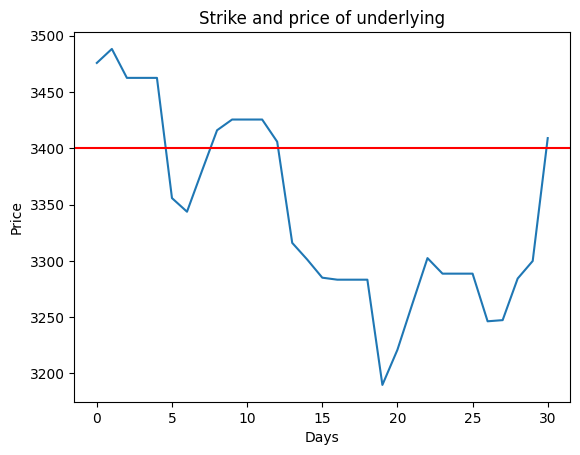

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(prices['price'])
ax.axhline(y=3400, color='r')

ax.set(xlabel='Days', ylabel='Price', title='Strike and price of underlying')

plt.show()

We can see that the option starts out profitable, then goes through a period of being out of the money and finally expires just slightly into the money. We thus expect our valuations to present us with a positive PV at first, followed by a PV of 0 and finally a positive PV on the last day.

### 5 Days in

We can see our first dip out of the money occurs around the 5 days mark, this would be the 21st of September. Below we run our valuation and find that indeed, the PV is 0.

In [17]:
get_daily_option_val("2021-09-21T08:00:00Z", portfolio_code)

,Present Value,Exposure,InstrumentName,Instrument/Definition/ContractSize,Quotes/Price,Holding/default/Units
0,0.00,0.00,AMZN 10/15/21 C3400,1.00,"3,343.63",100.00


### 20 Days in
Checking for the second period of being out of the money, we find that our valuation also returns a PV of 0 about 20 days into holding this option.

In [18]:
get_daily_option_val("2021-10-05T08:00:00Z", portfolio_code)

,Present Value,Exposure,InstrumentName,Instrument/Definition/ContractSize,Quotes/Price,Holding/default/Units
0,0.00,0.00,AMZN 10/15/21 C3400,1.00,"3,285.04",100.00


## Expiry date

In [19]:
get_daily_option_val("2021-10-15T00:00:00Z", portfolio_code)

,Present Value,Exposure,InstrumentName,Instrument/Definition/ContractSize,Quotes/Price,Holding/default/Units
0,902.00,902.00,AMZN 10/15/21 C3400,1.00,"3,409.02",100.00
1,"-1,700,000.00","-1,700,000.00",USD,1.00,NaN,"-1,700,000.00"
2,"340,902.00","340,902.00",Amazon.com,1.00,"3,409.02",100.00


# 6. Physical Settlement

If we have a look at what cashflows are occuring on the date of expiry, we can see that there is a negative cash flow for USD -340,000, which is the price we have to pay for the physical delivery of the underlying. We must however manually book in the underlying itself. We will accomplish this with a StockIn transaction, which will give us 100 units of Amazon in return for the negative cashflow we incur. 

In [20]:
upsertable_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=scope,
    code=portfolio_code,
    recipe_id_code="OptValuation",
    recipe_id_scope=scope,
    effective_at="2021-10-10T10:00:00Z",
    window_start="2021-10-10T10:00:00Z",
    window_end="2021-10-15T10:00:00Z",
)

lusid_response_to_data_frame(upsertable_cash_flows)

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/default/ParentLuid.key,properties.Transaction/default/ParentLuid.value.label_value,properties.Transaction/default/InstrumentEventId.key,properties.Transaction/default/InstrumentEventId.value.label_value,source,entry_date_time,transaction_status
0,txn001-LUID_0000GXWC-20211015-Cash-USD-Pay,CashFlow,LUID_0000GXWC,default,LUID_0000GXWC,2021-10-15 00:00:00+00:00,2021-10-15 00:00:00+00:00,"-340,000.00",1.00,Price,"-340,000.00",USD,1.00,USD,Transaction/default/ParentLuid,LUID_0000GXWC,Transaction/default/InstrumentEventId,LUID_0000GXWC-20211015-Cash-USD-Pay-v1,default,0001-01-01 00:00:00+00:00,Active


To upsert this cash flow as a transaction, we must first add the identifier of the desired instrument we want to credit, in our case we want to subtract from our USD position. 
Once we have the full transaction request, we can simply upsert this.

In [21]:
for x in upsertable_cash_flows.values:
    x.instrument_identifiers = {"Instrument/default/Currency": "USD"}

In [22]:
upsert_transactions = transaction_portfolios_api.upsert_transactions(
    scope=scope, code=portfolio_code, transaction_request=upsertable_cash_flows.values
)

Now that we have booked in our payment for the underlying, we have to add in a "StockIn" transaction, which will essentially add a position of Amazon to our books. In the case of our option, our contract size was 1 and the quantity was 100 thus we will add a position of 100 Amazon shares. We use a StockIn transaction for this as this will not create us a cost. We need this as we already booked the negative cashflow using the transaction in the cell above.

Additionally, we should also remove the option itself, as it has expired. We accomplish this with a StockOut transaction.

In [23]:
expiry_transactions = pd.read_csv("data/option_expiry_transaction.csv")
expiry_transactions

,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio
0,OptExp001,StockIn,AMZN,2021-10-15T00:00:00Z,2021-10-15T00:00:00Z,100,3400,"340,000.00",USD,equityOptionPortfolio
1,OptExp002,StockOut,AMZN_10/15/21_C3400,2021-10-16T00:00:00Z,2021-10-16T00:00:00Z,100,220,"22,000.00",USD,equityOptionPortfolio


In [24]:
for portfolio_code, grouped_df in expiry_transactions.groupby('portfolio'):

    transaction_request=[
            lm.TransactionRequest(
                transaction_id=row["txn_id"],
                type=row["type"],
                instrument_identifiers={
                    "Instrument/default/ClientInternal" :row["client_id"]
                },
                transaction_date=row["trade_date"],
                settlement_date=row["settlement_date"],
                units=row["quantity"],
                transaction_price=lm.TransactionPrice(
                    price=row["price"], type="Price"
                ),
                total_consideration=lm.CurrencyAndAmount(
                    amount=row["total_consideration"], currency=row["currency"]
                ),
            ) for index, row in grouped_df.iterrows()
        ]

    response = transaction_portfolios_api.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transaction_request=transaction_request
      )

    print(f"Transactions succesfully updated at time: {response.version.as_at_date}")

Transactions succesfully updated at time: 2022-01-06 17:08:02.916338+00:00


Now we can see what our portfolio looks like after the expiry date when the physical settlement has happened. 
We have a negative cash position of USD 340,000 and a positive position of USD 340,902 worth of Amazon shares.

This adds up to a present value of USD 902 for this portfolio, the value of our option upon expiry.

In [25]:
get_daily_option_val("2021-10-16T08:00:00Z", portfolio_code)

,Present Value,Exposure,InstrumentName,Instrument/Definition/ContractSize,Quotes/Price,Holding/default/Units
0,"-1,700,000.00","-1,700,000.00",USD,1.00,NaN,"-1,700,000.00"
1,"340,902.00","340,902.00",Amazon.com,1.00,"3,409.02",100.00
